# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install missingno

In [2]:
import pandas as pd
import numpy as np
import math
import json

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import missingno as msno
import seaborn as sns

from datetime import datetime

% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [4]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

### Protfolio Analysis

In [6]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [7]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [8]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [9]:
portfolio.shape

(10, 6)

In [10]:
def encode_channels():
    channels = []
    for lst in portfolio['channels']:
        for channel in lst:
            if channel not in channels:
                channels.append(channel)
    
    # one-hot encode channel
    for channel in channels:
        portfolio['channel_' + channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
    # drop channels column
    portfolio.drop(['channels'], axis=1, inplace=True)

In [11]:
encode_channels()
portfolio.head()

,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [12]:
print("Available Offers: \n\n")
for i in range(portfolio.shape[0]):
    row = portfolio.iloc[i]
    print("{}: Difficulty: {}, Duration: {}, Reward: {} ".format(row['offer_type'], row['difficulty'], row['duration'], row['reward']))

Available Offers: 


bogo: Difficulty: 10, Duration: 7, Reward: 10 
bogo: Difficulty: 10, Duration: 5, Reward: 10 
informational: Difficulty: 0, Duration: 4, Reward: 0 
bogo: Difficulty: 5, Duration: 7, Reward: 5 
discount: Difficulty: 20, Duration: 10, Reward: 5 
discount: Difficulty: 7, Duration: 7, Reward: 3 
discount: Difficulty: 10, Duration: 10, Reward: 2 
informational: Difficulty: 0, Duration: 3, Reward: 0 
bogo: Difficulty: 5, Duration: 5, Reward: 5 
discount: Difficulty: 10, Duration: 7, Reward: 2 


In [13]:
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [14]:
portfolio_offers = {}

for i in range(portfolio.shape[0]):
    row = portfolio.iloc[i]
    portfolio_offers[row['offer_id']] = row['offer_type'].upper() + '/C' + str(row['difficulty']) + '/R' + str(row['reward']) + '/T' + str(row['duration'])

portfolio_offers

{'ae264e3637204a6fb9bb56bc8210ddfd': 'BOGO/C10/R10/T7',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 'BOGO/C10/R10/T5',
 '3f207df678b143eea3cee63160fa8bed': 'INFORMATIONAL/C0/R0/T4',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'BOGO/C5/R5/T7',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'DISCOUNT/C20/R5/T10',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 'DISCOUNT/C7/R3/T7',
 'fafdcd668e3743c1bb461111dcafc2a4': 'DISCOUNT/C10/R2/T10',
 '5a8bc65990b245e5a138643cd4eb9837': 'INFORMATIONAL/C0/R0/T3',
 'f19421c1d4aa40978ebb69ca19b0e20d': 'BOGO/C5/R5/T5',
 '2906b810c7d4411798c6938adc9daaa5': 'DISCOUNT/C10/R2/T7'}

In [15]:
portfolio['offer_id'] = portfolio['offer_id'].apply(lambda x: portfolio_offers[x])

In [16]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,BOGO/C10/R10/T7,bogo,10,1,1,1,0
1,10,5,BOGO/C10/R10/T5,bogo,10,1,1,1,1
2,0,4,INFORMATIONAL/C0/R0/T4,informational,0,1,1,0,1
3,5,7,BOGO/C5/R5/T7,bogo,5,1,1,0,1
4,20,10,DISCOUNT/C20/R5/T10,discount,5,1,0,0,1


In [17]:
available_offers = list(portfolio['offer_type'].value_counts().keys())
available_offers

['bogo', 'discount', 'informational']

In [18]:
def encode_offer_type():
    offer_types = []
    # one-hot encode offers
    for offer in range(len(available_offers)):
        portfolio['offer_' + available_offers[offer]] = \
            portfolio['offer_type'].apply(lambda x: 1 if x == available_offers[offer] else 0)
    
    # drop offer_type column
    portfolio.drop(['offer_type'], axis=1, inplace=True)

encode_offer_type()

In [19]:
portfolio.head()

,difficulty,duration,offer_id,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,10,7,BOGO/C10/R10/T7,10,1,1,1,0,1,0,0
1,10,5,BOGO/C10/R10/T5,10,1,1,1,1,1,0,0
2,0,4,INFORMATIONAL/C0/R0/T4,0,1,1,0,1,0,0,1
3,5,7,BOGO/C5/R5/T7,5,1,1,0,1,1,0,0
4,20,10,DISCOUNT/C20/R5/T10,5,1,0,0,1,0,1,0


# Profile Analysis

In [20]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [21]:
profile.shape

(17000, 5)

In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


#### Null values

In [23]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [24]:
profile[profile['age'] == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

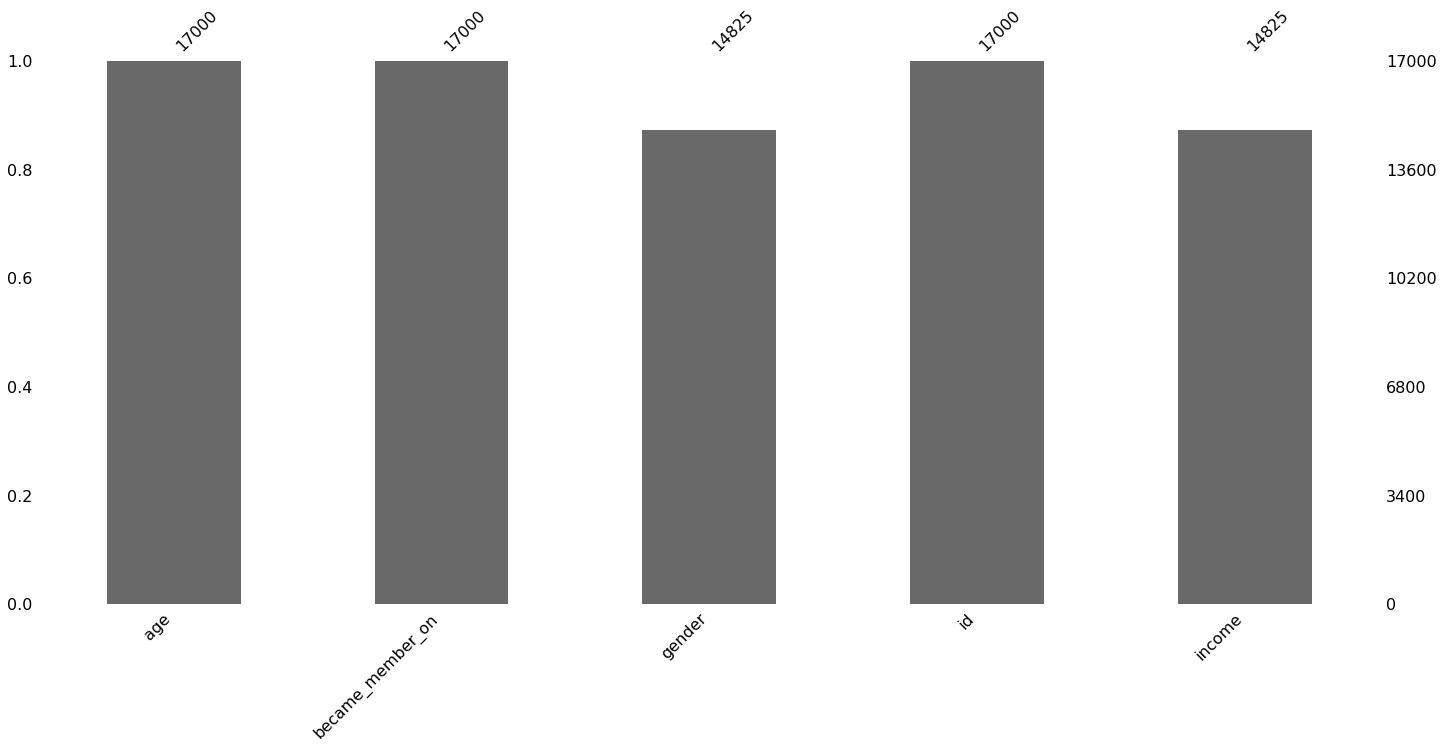

In [25]:
 msno.bar(profile)

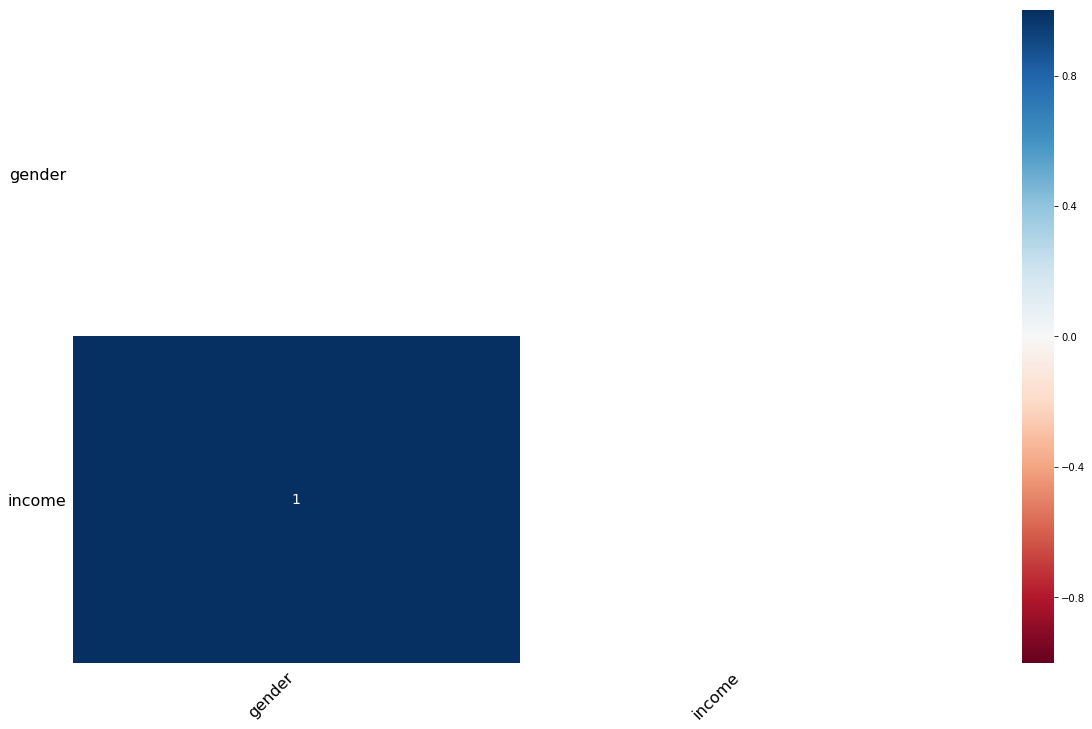

In [26]:
 msno.heatmap(profile)

In [27]:
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


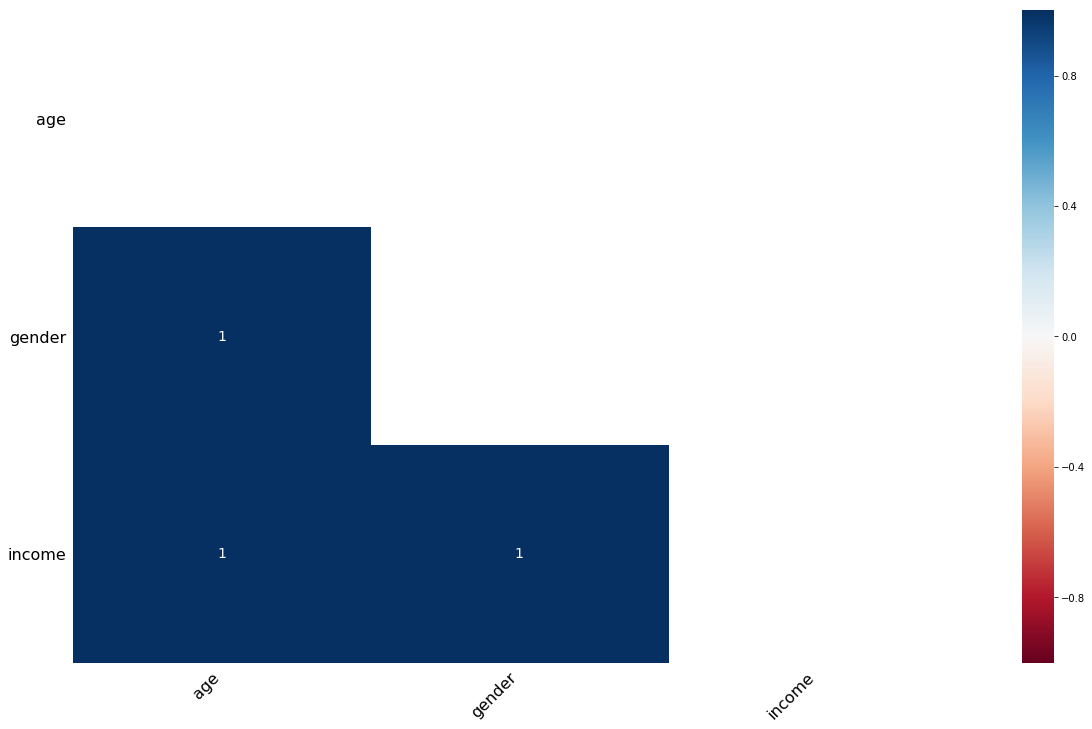

In [28]:
 msno.heatmap(profile)

118 is a placeholder for no age value available and is not an actual age.

#### Distribution of age, income and gender

In [29]:
profile = profile[profile['age'].isnull() == False]

In [30]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null float64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 694.9+ KB


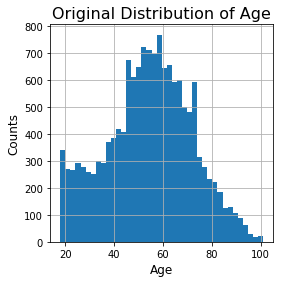

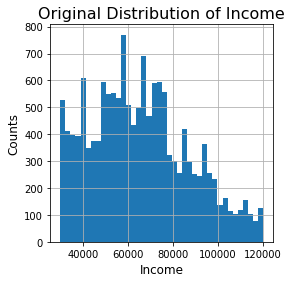

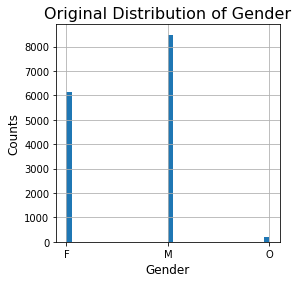

In [31]:
vars = {
    'Age': 'age',
    'Income': 'income',
    'Gender': 'gender'
}
for key, value in vars.items():
    fig, ax = plt.subplots(figsize=(4,4));
    profile[value].hist(bins=40, ax=ax);
    ax.set_title("Original Distribution of {}".format(key), fontsize=16)
    ax.set_xlabel(key, fontsize=12);
    ax.set_ylabel("Counts", fontsize=12);

In [32]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['member_year'] = profile['became_member_on'].dt.year
profile['member_month'] = profile['became_member_on'].dt.month
profile['member_day'] = profile['became_member_on'].dt.day

In [33]:
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
member_year         0
member_month        0
member_day          0
dtype: int64

In [34]:
def create_member_group(days):
    if days == 744:
        return 'since_2_year'
    elif 744 <= days <= 3*365:
        return 'since_3_year'
    elif 3*365 <= days <= 4*365:
        return 'since_3_year'
    elif 4*365 <= days <= 5*365:
        return 'since_4_year'
    elif 5*365 <= days <= 6*365:
        return 'since_5_year'
    elif 6*365 <= days <= 7*365:
        return 'since_6_year'
    elif 7*365 <= days <= 8*365:
        return 'since_7_year'
    else:
        return np.nan
    
profile['member_since_days'] = np.abs(profile['became_member_on'] - datetime.now()).dt.days.apply(create_member_group)
profile.head()

,age,became_member_on,gender,id,income,member_year,member_month,member_day,member_since_days
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,since_3_year
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,since_3_year
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,since_3_year
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,since_3_year
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,since_3_year


In [35]:
profile.head()

,age,became_member_on,gender,id,income,member_year,member_month,member_day,member_since_days
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,since_3_year
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,since_3_year
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,since_3_year
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,since_3_year
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,since_3_year


In [36]:
profile['member_year'].value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: member_year, dtype: int64

(array([  274.,     0.,   662.,     0.,  1597.,     0.,  3024.,     0.,
         5599.,  3669.]),
 array([ 2013. ,  2013.5,  2014. ,  2014.5,  2015. ,  2015.5,  2016. ,
         2016.5,  2017. ,  2017.5,  2018. ]),
 <a list of 10 Patch objects>)

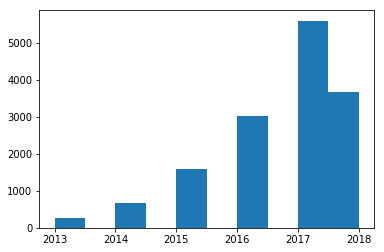

In [37]:
plt.hist(profile['member_year'])

In [43]:
profile = create_dummy_df(profile, ['gender'], False)

In [44]:
profile.head()

,age,became_member_on,id,income,member_year,member_month,member_day,member_since_days,gender_F,gender_M,gender_O
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,since_3_year,1,0,0
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,since_3_year,1,0,0
5,68.0,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,since_3_year,0,1,0
8,65.0,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,since_3_year,0,1,0
12,58.0,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,since_3_year,0,1,0


In [45]:
profile[profile['age'] > 0].max()['age'], profile[profile['age'] > 0].min()['age']

(101.0, 18.0)

In [46]:
def create_age_group(age):
    if age <= 38:
        return 1
    elif 39 <= age <= 54:
        return 2
    elif 55 <= age <=73:
        return 3
    elif 74 <= age <= 101:
        return 4
    else:
        return np.nan
    
profile['age_group'] = profile['age'].apply(create_age_group)
profile.head()

,age,became_member_on,id,income,member_year,member_month,member_day,member_since_days,gender_F,gender_M,gender_O,age_group
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,since_3_year,1,0,0,3
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,since_3_year,1,0,0,4
5,68.0,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,since_3_year,0,1,0,3
8,65.0,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,since_3_year,0,1,0,3
12,58.0,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,since_3_year,0,1,0,3


In [47]:
profile.rename(columns = {'id':'person'}, inplace = True)
profile.head()

,age,became_member_on,person,income,member_year,member_month,member_day,member_since_days,gender_F,gender_M,gender_O,age_group
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,since_3_year,1,0,0,3
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,since_3_year,1,0,0,4
5,68.0,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,since_3_year,0,1,0,3
8,65.0,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,since_3_year,0,1,0,3
12,58.0,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,since_3_year,0,1,0,3


In [48]:
profile.isnull().sum()

age                  0
became_member_on     0
person               0
income               0
member_year          0
member_month         0
member_day           0
member_since_days    0
gender_F             0
gender_M             0
gender_O             0
age_group            0
dtype: int64

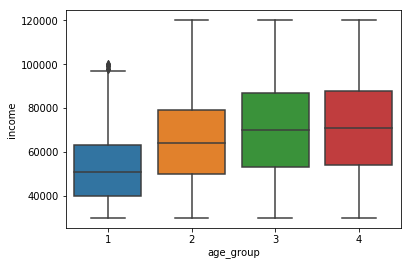

In [49]:
sns.boxplot(x="age_group", y="income", data=profile)

(array([    21.,      0.,  10399.,      0.,   2971.,      0.,    739.,
             0.,    674.,     21.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

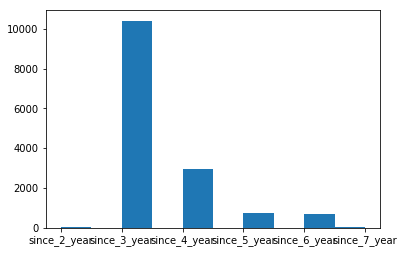

In [50]:
plt.hist(profile['member_since_days'])

### Transcript Analysis

In [51]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [52]:
# Shape of the transaction
transcript.shape

(306534, 4)

In [53]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


No missing values in this dataframe

In [54]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [55]:
list(transcript[transcript['event'] == 'offer viewed']['value'].head())

[{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},
 {'offer id': '5a8bc65990b245e5a138643cd4eb9837'},
 {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},
 {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},
 {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}]

In [56]:
transcript[transcript['event'] == 'offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [57]:
list(transcript[transcript['event'] == 'offer received']['value'].head())

[{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},
 {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},
 {'offer id': '2906b810c7d4411798c6938adc9daaa5'},
 {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},
 {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}]

In [58]:
transcript[transcript['event'] == 'offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [59]:
list(transcript[transcript['event'] == 'offer completed']['value'].head())

[{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2},
 {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
 {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5},
 {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10},
 {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}]

In [60]:
transcript[transcript['event'] == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [61]:
list(transcript[transcript['event'] == 'transaction']['value'].head())

[{'amount': 0.8300000000000001},
 {'amount': 34.56},
 {'amount': 13.23},
 {'amount': 19.51},
 {'amount': 18.97}]

In [62]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [63]:
transcript[transcript['person'] == '02c083884c7d45b39cc68e1314fec56c'].head()

,event,person,time,value
27,offer received,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
15565,transaction,02c083884c7d45b39cc68e1314fec56c,6,{'amount': 1.44}
18071,transaction,02c083884c7d45b39cc68e1314fec56c,12,{'amount': 4.5600000000000005}


In [64]:
test = create_dummy_df(transcript, ['event'], False)
test[(test['event_offer received'] == 1) & (test['event_transaction'] == 1)].head()

,person,time,value,event_offer completed,event_offer received,event_offer viewed,event_transaction


In [65]:
test[(test['event_offer received'] == 1) & (test['event_offer viewed'] == 1)].head()

,person,time,value,event_offer completed,event_offer received,event_offer viewed,event_transaction


In [66]:
test[(test['event_offer received'] == 1) & (test['event_offer completed'] == 1)].head()

,person,time,value,event_offer completed,event_offer received,event_offer viewed,event_transaction


In [67]:
test[(test['event_transaction'] == 1) & (test['event_offer completed'] == 1)].head()

,person,time,value,event_offer completed,event_offer received,event_offer viewed,event_transaction


In [68]:
# Create column value type - offer id/offer_id or amount
transcript['type'] = transcript['value'].apply(lambda x : 'offer_id' if (list(x.keys())[0] == 'offer id' or list(x.keys())[0] == 'offer_id') else list(x.keys())[0])
transcript['type'].value_counts()

offer_id    167581
amount      138953
Name: type, dtype: int64

In [69]:
# Create column value id containing offer id or type_0
transcript['offer_id'] = transcript['value'].apply(lambda x : portfolio_offers[list(x.values())[0]] if (list(x.keys())[0] == 'offer id' or list(x.keys())[0] == 'offer_id') else 'NoPromotionApplied')
transcript.head()

,event,person,time,value,type,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,DISCOUNT/C20/R5/T10
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer_id,DISCOUNT/C10/R2/T10
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer_id,BOGO/C10/R10/T5


In [70]:
transcript[transcript['event'] == 'transaction'].head()

,event,person,time,value,type,offer_id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},amount,NoPromotionApplied
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},amount,NoPromotionApplied
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},amount,NoPromotionApplied
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},amount,NoPromotionApplied
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},amount,NoPromotionApplied


In [71]:
transcript.isnull().sum()

event       0
person      0
time        0
value       0
type        0
offer_id    0
dtype: int64

In [72]:
transcript_offer = transcript[transcript['type']=='offer_id']
transcript_offer = pd.merge(transcript_offer, profile, how='left', on='person')
print(transcript_offer.shape, transcript.shape)
transcript_offer.head()

(167581, 17) (306534, 6)


,event,person,time,value,type,offer_id,age,became_member_on,income,member_year,member_month,member_day,member_since_days,gender_F,gender_M,gender_O,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,DISCOUNT/C20/R5/T10,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,4.0,26.0,since_3_year,0.0,1.0,0.0,3.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer_id,DISCOUNT/C10/R2/T10,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer_id,BOGO/C10/R10/T5,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
transcript_offer = transcript_offer.dropna()
transcript_offer.isnull().sum()

event                0
person               0
time                 0
value                0
type                 0
offer_id             0
age                  0
became_member_on     0
income               0
member_year          0
member_month         0
member_day           0
member_since_days    0
gender_F             0
gender_M             0
gender_O             0
age_group            0
dtype: int64

In [74]:
profile[profile['person'] == '68617ca6246f4fbc85e91a2a49552598']

,age,became_member_on,person,income,member_year,member_month,member_day,member_since_days,gender_F,gender_M,gender_O,age_group


In [75]:
transcript_offer[transcript_offer['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,type,offer_id,age,became_member_on,income,member_year,member_month,member_day,member_since_days,gender_F,gender_M,gender_O,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
14928,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
26541,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
27253,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},offer_id,INFORMATIONAL/C0/R0/T3,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
50486,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},offer_id,INFORMATIONAL/C0/R0/T3,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
80822,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},offer_id,BOGO/C10/R10/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
93599,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},offer_id,BOGO/C10/R10/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
109739,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
125208,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,offer_id,BOGO/C10/R10/T7,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0
125209,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,offer_id,BOGO/C5/R5/T5,75.0,2017-05-09,100000.0,2017.0,5.0,9.0,since_3_year,1.0,0.0,0.0,4.0


In [76]:
transcript_offer_group = transcript_offer.groupby(['person', 'offer_id', 'event']).count()
transcript_offer_group

time  \
person                           offer_id               event                   
0009655768c64bdeb2e877511632db8f BOGO/C5/R5/T5          offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 DISCOUNT/C10/R2/T10    offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 DISCOUNT/C10/R2/T7     offer completed     1   
                                                        offer received      1   
                                 INFORMATIONAL/C0/R0/T3 offer received      1   
                                                        offer viewed        1   
                                 INFORMATIONAL/C0/R0/T4 offer received      1   
                                                        offer viewed        1   
0011e0d4e6b944f998e987f904e8c1e5 BOGO/C5/R5/T7          offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 DISCOUNT/C20/R5/T10    offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 DISCOUNT/C7/R3/T7      offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 INFORMATIONAL/C0/R0/T3 offer received      1   
                                                        offer viewed        1   
                                 INFORMATIONAL/C0/R0/T4 offer received      1   
                                                        offer viewed        1   
0020c2b971eb4e9188eac86d93036a77 BOGO/C10/R10/T5        offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 BOGO/C10/R10/T7        offer received      1   
                                 DISCOUNT/C10/R2/T10    offer completed     2   
...                                                                       ...   
fff7576017104bcc8677a8d63322b5e1 BOGO/C5/R5/T7          offer completed     1   
                                                        offer received      1   
                                 DISCOUNT/C10/R2/T10    offer completed     2   
                                                        offer received      2   
                                                        offer viewed        2   
fff8957ea8b240a6b5e634b6ee8eafcf BOGO/C10/R10/T5        offer received      1   
                                                        offer viewed        1   
                                 DISCOUNT/C10/R2/T10    offer received      1   
                                                        offer viewed        1   
                                 INFORMATIONAL/C0/R0/T4 offer received      1   
fffad4f4828548d1b5583907f2e9906b BOGO/C5/R5/T5          offer completed     2   
                                                        offer received      2   
                                                        offer viewed        2   
                                 BOGO/C5/R5/T7          offer completed     1   
                                                        offer received      1   
                                                        offer viewed        1   
                                 INFORMATIONAL/C0/R0/T3 offer received      1   
                       

In [77]:
transcript_offer = pd.merge(transcript_offer, portfolio, how='left', on='offer_id')
print(transcript_offer.shape, transcript.shape)
transcript_offer.head()

(148805, 27) (306534, 6)


,event,person,time,value,type,offer_id,age,became_member_on,income,member_year,...,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,...,5,7,5,1,1,0,1,1,0,0
1,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,...,10,7,2,1,1,0,1,0,1,0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,...,5,5,5,1,1,1,1,1,0,0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},offer_id,INFORMATIONAL/C0/R0/T4,58.0,2017-11-11,51000.0,2017.0,...,0,4,0,1,1,0,1,0,0,1
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,DISCOUNT/C20/R5/T10,61.0,2017-09-11,57000.0,2017.0,...,20,10,5,1,0,0,1,0,1,0


In [78]:
transcript_offer.columns

Index(['event', 'person', 'time', 'value', 'type', 'offer_id', 'age',
       'became_member_on', 'income', 'member_year', 'member_month',
       'member_day', 'member_since_days', 'gender_F', 'gender_M', 'gender_O',
       'age_group', 'difficulty', 'duration', 'reward', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_bogo',
       'offer_discount', 'offer_informational'],
      dtype='object')

In [79]:
transcript_offer.isnull().sum()

event                  0
person                 0
time                   0
value                  0
type                   0
offer_id               0
age                    0
became_member_on       0
income                 0
member_year            0
member_month           0
member_day             0
member_since_days      0
gender_F               0
gender_M               0
gender_O               0
age_group              0
difficulty             0
duration               0
reward                 0
channel_email          0
channel_mobile         0
channel_social         0
channel_web            0
offer_bogo             0
offer_discount         0
offer_informational    0
dtype: int64

In [80]:
transcript_offer_received = transcript_offer[transcript_offer['event']=='offer received']
transcript_offer_received.rename(index=str, columns={"time":"time_received"}, inplace=True)
transcript_offer_received.drop(['event'], axis=1, inplace=True)
print(transcript_offer_received.shape)
transcript_offer_received.head()

(66501, 26)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,5,7,5,1,1,0,1,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,4.0,...,10,7,2,1,1,0,1,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,5,5,1,1,1,1,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},offer_id,INFORMATIONAL/C0/R0/T4,58.0,2017-11-11,51000.0,2017.0,11.0,...,0,4,0,1,1,0,1,0,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,DISCOUNT/C20/R5/T10,61.0,2017-09-11,57000.0,2017.0,9.0,...,20,10,5,1,0,0,1,0,1,0


In [81]:
transcript_offer_viewed = transcript_offer[transcript_offer['event']=='offer viewed']
transcript_offer_viewed.rename(index=str, columns={"time": "time_viewed"}, inplace=True)
cols_to_drop = ['event', 'value', 'type', 'age', 'gender_F', 'gender_M', 'gender_O', \
                'income', 'member_year', 'member_month', 'member_day', 'age_group', \
                'difficulty', 'duration', 'reward', 'age_group', \
                'channel_email', 'channel_mobile', 'channel_social', 'channel_web', \
               'became_member_on', 'member_since_days', 'offer_discount', 'offer_bogo', \
               'offer_informational']
transcript_offer_viewed.drop(cols_to_drop, axis=1, inplace=True)
print(transcript_offer_viewed.shape)
transcript_offer_viewed.head()

(49860, 3)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,person,time_viewed,offer_id
11023,389bc3fa690240e798340f5a15918d5c,0,BOGO/C5/R5/T5
11024,d1ede868e29245ea91818a903fec04c6,0,INFORMATIONAL/C0/R0/T3
11025,102e9454054946fda62242d2e176fdce,0,BOGO/C10/R10/T5
11026,02c083884c7d45b39cc68e1314fec56c,0,BOGO/C10/R10/T7
11027,be8a5d1981a2458d90b255ddc7e0d174,0,INFORMATIONAL/C0/R0/T3


In [82]:
transcript_offer_completed = transcript_offer[transcript_offer['event']=='offer completed']
transcript_offer_completed.rename(index=str, columns={"time":"time_completed"}, inplace=True)
transcript_offer_completed.drop(cols_to_drop, axis=1, inplace=True)
print(transcript_offer_completed.shape)
transcript_offer_completed.head()

(32444, 3)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,person,time_completed,offer_id
11029,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,DISCOUNT/C10/R2/T7
11037,fe97aa22dd3e48c8b143116a8403dd52,0,DISCOUNT/C10/R2/T10
11042,629fc02d56414d91bca360decdfa9288,0,BOGO/C5/R5/T7
11048,676506bad68e4161b9bbaffeb039626b,0,BOGO/C10/R10/T7
11051,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,BOGO/C10/R10/T5


In [83]:
transcript_offer_received[transcript_offer_received['person'] == '43aae84d54144c1bacf027bbb00f4ffa']

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
9687,43aae84d54144c1bacf027bbb00f4ffa,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,58.0,2017-08-29,67000.0,2017.0,8.0,...,5,5,5,1,1,1,1,1,0,0
33862,43aae84d54144c1bacf027bbb00f4ffa,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,58.0,2017-08-29,67000.0,2017.0,8.0,...,5,5,5,1,1,1,1,1,0,0
59001,43aae84d54144c1bacf027bbb00f4ffa,336,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,58.0,2017-08-29,67000.0,2017.0,8.0,...,5,7,5,1,1,0,1,1,0,0
107052,43aae84d54144c1bacf027bbb00f4ffa,504,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,DISCOUNT/C20/R5/T10,58.0,2017-08-29,67000.0,2017.0,8.0,...,20,10,5,1,0,0,1,0,1,0
131003,43aae84d54144c1bacf027bbb00f4ffa,576,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},offer_id,DISCOUNT/C7/R3/T7,58.0,2017-08-29,67000.0,2017.0,8.0,...,7,7,3,1,1,1,1,0,1,0


In [84]:
transcript_offer_viewed[transcript_offer_viewed['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,time_viewed,offer_id
12984,78afa995795e4d85b5d9ceeca43f5fef,6,BOGO/C5/R5/T7
44632,78afa995795e4d85b5d9ceeca43f5fef,216,INFORMATIONAL/C0/R0/T3
82769,78afa995795e4d85b5d9ceeca43f5fef,408,BOGO/C10/R10/T7
134874,78afa995795e4d85b5d9ceeca43f5fef,582,BOGO/C5/R5/T5


In [85]:
all_offers = pd.merge(transcript_offer_received, transcript_offer_viewed, on=['person', 'offer_id'], how='left')
all_offers = pd.merge(all_offers, transcript_offer_completed, on=['person', 'offer_id'], how='left')
print(all_offers.shape)
all_offers.head()

(102693, 28)


,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,5,1,1,0,1,1,0,0,6.0,132.0
1,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,4.0,...,2,1,1,0,1,0,1,0,18.0,NaN
2,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,1,1,1,1,1,0,0,0.0,60.0
3,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,1,1,1,1,1,0,0,0.0,600.0
4,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,1,1,1,1,1,0,0,504.0,60.0


In [86]:
all_offers.columns

Index(['person', 'time_received', 'value', 'type', 'offer_id', 'age',
       'became_member_on', 'income', 'member_year', 'member_month',
       'member_day', 'member_since_days', 'gender_F', 'gender_M', 'gender_O',
       'age_group', 'difficulty', 'duration', 'reward', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_bogo',
       'offer_discount', 'offer_informational', 'time_viewed',
       'time_completed'],
      dtype='object')

In [290]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [42]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            # Convert categorical variable into dummy/indicator variable
            dummy_cols_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)
            # Remove the converted column
            df_without_col = df.drop(col, axis=1)
            # Concatenate the two columns
            df = pd.concat([df_without_col, dummy_cols_df], axis=1)
        except:
            continue

    return df

1. (time offer viewed > time offer received) and (time offer completed > time offer viewed)
2. (time offer viewed > time offer received) and (time completed is null)
3. both time offer viewed and time offer completed are null

In [87]:
# Get valid data based on time window
all_offers = all_offers[((all_offers['time_viewed'] >= all_offers['time_received']) &\
                        ((all_offers['time_completed'] >= all_offers['time_viewed'])
                        | all_offers['time_completed'].isnull())) |
                        (all_offers['time_viewed'].isnull() &\
                         all_offers['time_completed'].isnull())]

print(all_offers.shape)
all_offers.head()

(67037, 28)


,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,5,1,1,0,1,1,0,0,6.0,132.0
1,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,4.0,...,2,1,1,0,1,0,1,0,18.0,NaN
2,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,1,1,1,1,1,0,0,0.0,60.0
3,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,1,1,1,1,1,0,0,0.0,600.0
5,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,5,1,1,1,1,1,0,0,504.0,600.0


In [88]:
time_of_expiry_df = pd.DataFrame({ 'time_of_expiry': np.array(all_offers['time_received']) + np.array(all_offers['duration']) })
all_offers = pd.concat([all_offers, time_of_expiry_df], axis=1)

In [89]:
all_offers[all_offers['time_received'] > 0].head()

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed,time_of_expiry
17082,78afa995795e4d85b5d9ceeca43f5fef,168.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},offer_id,INFORMATIONAL/C0/R0/T3,75.0,2017-05-09,100000.0,2017.0,5.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,216.0,NaN,172.0
17083,389bc3fa690240e798340f5a15918d5c,168.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,192.0,498.0,173.0
17084,389bc3fa690240e798340f5a15918d5c,168.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,438.0,498.0,175.0
17085,2eeac8d8feae4a8cad5a6af0499a211d,168.0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},offer_id,DISCOUNT/C7/R3/T7,58.0,2017-11-11,51000.0,2017.0,11.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,168.0,NaN,175.0
17086,aa4862eba776480b8bb9c68455b8c2e1,168.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer_id,BOGO/C10/R10/T5,61.0,2017-09-11,57000.0,2017.0,9.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,168.0,210.0,175.0


In [90]:
all_offers['successful_offer'] = ((all_offers['time_received'] <= all_offers['time_viewed']) & (all_offers['time_viewed'] <= all_offers['time_completed']) & (all_offers['time_completed'] <= all_offers['time_of_expiry'])).apply(lambda x: int(x == True))
all_offers['tried_offer'] = ((all_offers['time_received'] <= all_offers['time_viewed']) & (all_offers['time_viewed'] <= all_offers['time_of_expiry']) & ((all_offers['time_of_expiry'] < all_offers['time_completed']) | (np.isnan(all_offers['time_completed'])))).apply(lambda x: int(x == True))
all_offers['failed_offer'] = ((all_offers['successful_offer'] == 1) | (all_offers['tried_offer'] == 1)).apply(lambda x: int(x == False))
all_offers.head()

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed,time_of_expiry,successful_offer,tried_offer,failed_offer
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,1.0,1.0,0.0,0.0,6.0,132.0,7.0,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,4.0,...,1.0,0.0,1.0,0.0,18.0,NaN,7.0,0,0,1
2,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,0.0,0.0,60.0,5.0,0,1,0
3,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,0.0,0.0,600.0,5.0,0,1,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0,0,1


In [91]:
transcript_offer_received[transcript_offer_received.duplicated(subset=['time_received', 'person', 'offer_id'])]

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational


In [92]:
all_offers[all_offers.duplicated(subset=['time_received', 'person', 'offer_id'])]

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed,time_of_expiry,successful_offer,tried_offer,failed_offer
3,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,0.0,0.0,600.0,5.0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,0.0,504.0,600.0,4.0,0,0,1
10,4b0da7e80e5945209a1fdddfe813dbe0,0.0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},offer_id,BOGO/C10/R10/T7,64.0,2017-09-09,100000.0,2017.0,9.0,...,0.0,1.0,0.0,0.0,510.0,510.0,4.0,0,0,1
12,c27e0d6ab72c455a8bb66d980963de60,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},offer_id,INFORMATIONAL/C0/R0/T4,78.0,2017-06-16,71000.0,2017.0,6.0,...,1.0,0.0,0.0,1.0,348.0,NaN,10.0,0,0,1
14,d53717f5400c4e84affdaeda9dd926b3,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer_id,DISCOUNT/C20/R5/T10,88.0,2017-05-18,53000.0,2017.0,5.0,...,1.0,0.0,1.0,0.0,30.0,624.0,10.0,0,0,1
15,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0,0,1
16,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0,0,1
18,f806632c011441378d4646567f357a21,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer_id,DISCOUNT/C10/R2/T10,42.0,2013-08-11,69000.0,2013.0,8.0,...,1.0,0.0,1.0,0.0,18.0,462.0,10.0,0,0,1
19,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0,0,1
20,f806632c011441378d4646567f357a21,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer_id,DISCOUNT/C10/R2/T10,42.0,2013-08-11,69000.0,2013.0,8.0,...,1.0,0.0,1.0,0.0,408.0,462.0,7.0,0,0,1


In [93]:
all_offers[all_offers.duplicated(subset=['time_received', 'person', 'offer_id'])][['person', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_of_expiry', 'successful_offer', 'tried_offer', 'failed_offer']].head()

,person,offer_id,time_received,time_viewed,time_completed,time_of_expiry,successful_offer,tried_offer,failed_offer
3,389bc3fa690240e798340f5a15918d5c,BOGO/C5/R5/T5,0.0,0.0,600.0,5.0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,BOGO/C5/R5/T5,0.0,504.0,600.0,4.0,0,0,1
10,4b0da7e80e5945209a1fdddfe813dbe0,BOGO/C10/R10/T7,0.0,510.0,510.0,4.0,0,0,1
12,c27e0d6ab72c455a8bb66d980963de60,INFORMATIONAL/C0/R0/T4,0.0,348.0,NaN,10.0,0,0,1
14,d53717f5400c4e84affdaeda9dd926b3,DISCOUNT/C20/R5/T10,0.0,30.0,624.0,10.0,0,0,1


In [94]:
all_offers.drop_duplicates(subset=['time_received', 'person', 'offer_id'], keep='first', inplace=True)

In [95]:
print(all_offers.shape)

(55748, 32)


In [96]:
all_offers.columns

Index(['person', 'time_received', 'value', 'type', 'offer_id', 'age',
       'became_member_on', 'income', 'member_year', 'member_month',
       'member_day', 'member_since_days', 'gender_F', 'gender_M', 'gender_O',
       'age_group', 'difficulty', 'duration', 'reward', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_bogo',
       'offer_discount', 'offer_informational', 'time_viewed',
       'time_completed', 'time_of_expiry', 'successful_offer', 'tried_offer',
       'failed_offer'],
      dtype='object')

In [97]:
all_offers.head()

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed,time_of_expiry,successful_offer,tried_offer,failed_offer
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,1.0,1.0,0.0,0.0,6.0,132.0,7.0,0,1,0
1,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer_id,DISCOUNT/C10/R2/T7,68.0,2018-04-26,70000.0,2018.0,4.0,...,1.0,0.0,1.0,0.0,18.0,NaN,7.0,0,0,1
2,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,0.0,0.0,60.0,5.0,0,1,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0,0,1
6,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},offer_id,INFORMATIONAL/C0/R0/T4,58.0,2017-11-11,51000.0,2017.0,11.0,...,1.0,0.0,0.0,1.0,NaN,NaN,10.0,0,0,1


In [98]:
all_offers.isnull().sum()

person                     1
time_received              1
value                      1
type                       1
offer_id                   1
age                        1
became_member_on           1
income                     1
member_year                1
member_month               1
member_day                 1
member_since_days          1
gender_F                   1
gender_M                   1
gender_O                   1
age_group                  1
difficulty                 1
duration                   1
reward                     1
channel_email              1
channel_mobile             1
channel_social             1
channel_web                1
offer_bogo                 1
offer_discount             1
offer_informational        1
time_viewed             9298
time_completed         31382
time_of_expiry         18480
successful_offer           0
tried_offer                0
failed_offer               0
dtype: int64

In [99]:
all_offers = all_offers.drop(4)

In [100]:
transcript_transaction = transcript[transcript['type']=='amount']
transcript_transaction['amount_spent'] = transcript_transaction['value'].apply(lambda x: list(x.values())[0])
transcript_transaction.drop(['event', 'value', 'type', 'offer_id'], axis=1, inplace=True)
transcript_transaction.rename(index=str, columns={"time": "time_spent"}, inplace=True)
print(transcript_transaction.shape)
transcript_transaction.head()

(138953, 3)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,person,time_spent,amount_spent
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [101]:
# get subset of offers that are successfully completed or tried but not failed
succ_tried_offers = all_offers[(all_offers['successful_offer']==1) | (all_offers['tried_offer']==1)]
print(succ_tried_offers.shape)
succ_tried_offers.head()

(21488, 32)


,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,channel_web,offer_bogo,offer_discount,offer_informational,time_viewed,time_completed,time_of_expiry,successful_offer,tried_offer,failed_offer
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,1.0,1.0,0.0,0.0,6.0,132.0,7.0,0,1,0
2,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,1.0,1.0,0.0,0.0,0.0,60.0,5.0,0,1,0
29,102e9454054946fda62242d2e176fdce,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer_id,BOGO/C10/R10/T5,69.0,2016-08-14,57000.0,2016.0,8.0,...,1.0,1.0,0.0,0.0,0.0,6.0,7.0,1,0,0
32,02c083884c7d45b39cc68e1314fec56c,0.0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},offer_id,BOGO/C10/R10/T7,20.0,2016-07-11,30000.0,2016.0,7.0,...,0.0,1.0,0.0,0.0,0.0,NaN,7.0,0,1,0
35,be8a5d1981a2458d90b255ddc7e0d174,0.0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},offer_id,INFORMATIONAL/C0/R0/T3,39.0,2014-05-27,51000.0,2014.0,5.0,...,0.0,0.0,0.0,1.0,0.0,NaN,7.0,0,1,0


In [102]:
succ_tried_offers = pd.merge(succ_tried_offers, transcript_transaction, on='person', how='left')

In [103]:
succ_tried_offers.shape

(190075, 34)

In [104]:
succ_tried_offers.head(100)

,person,time_received,value,type,offer_id,age,became_member_on,income,member_year,member_month,...,offer_discount,offer_informational,time_viewed,time_completed,time_of_expiry,successful_offer,tried_offer,failed_offer,time_spent,amount_spent
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,132.0,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,144.0,17.78
2,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,222.0,19.67
3,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,240.0,29.72
4,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,378.0,23.93
5,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,510.0,21.72
6,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer_id,BOGO/C5/R5/T7,75.0,2017-05-09,100000.0,2017.0,5.0,...,0.0,0.0,6.0,132.0,7.0,0,1,0,534.0,26.56
7,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,0.0,0.0,0.0,60.0,5.0,0,1,0,60.0,9.54
8,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,0.0,0.0,0.0,60.0,5.0,0,1,0,498.0,15.63
9,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},offer_id,BOGO/C5/R5/T5,65.0,2018-02-09,53000.0,2018.0,2.0,...,0.0,0.0,0.0,60.0,5.0,0,1,0,600.0,11.26


In [105]:
def check_offer_transactions(df):
    if df['successful_offer'] == 1:
        if (df['time_spent'] >= df['time_received']) and (df['time_spent'] <= df['time_completed']):
            return 1
        else:
            return 0
    else:
        if (df['time_spent'] >= df['time_received']) and (df['time_spent'] <= df['time_of_expiry']):
            return 1
        else:
            return 0

succ_tried_offers['spent_during_offer'] = succ_tried_offers.apply(check_offer_transactions, axis=1)

In [106]:
succ_tried_offers = succ_tried_offers[succ_tried_offers['spent_during_offer']==1]

In [107]:
succ_tried_offers.shape

(25254, 35)

In [108]:
succ_tried_offers.columns

Index(['person', 'time_received', 'value', 'type', 'offer_id', 'age',
       'became_member_on', 'income', 'member_year', 'member_month',
       'member_day', 'member_since_days', 'gender_F', 'gender_M', 'gender_O',
       'age_group', 'difficulty', 'duration', 'reward', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_bogo',
       'offer_discount', 'offer_informational', 'time_viewed',
       'time_completed', 'time_of_expiry', 'successful_offer', 'tried_offer',
       'failed_offer', 'time_spent', 'amount_spent', 'spent_during_offer'],
      dtype='object')

(array([    16.,      0.,  15116.,      0.,   5768.,      0.,   2124.,
             0.,   2159.,     71.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

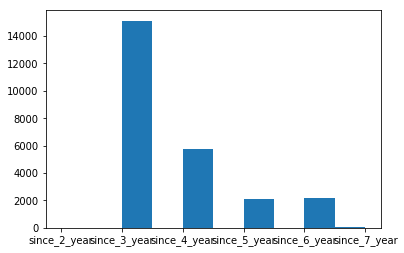

In [109]:
plt.hist(succ_tried_offers['member_since_days'])

[Text(0,0,'BOGO/C10/R10/T5'),
 Text(0,0,'BOGO/C10/R10/T7'),
 Text(0,0,'INFORMATIONAL/C0/R0/T3'),
 Text(0,0,'DISCOUNT/C10/R2/T7'),
 Text(0,0,'INFORMATIONAL/C0/R0/T4'),
 Text(0,0,'BOGO/C5/R5/T7'),
 Text(0,0,'DISCOUNT/C10/R2/T10'),
 Text(0,0,'BOGO/C5/R5/T5'),
 Text(0,0,'DISCOUNT/C7/R3/T7'),
 Text(0,0,'DISCOUNT/C20/R5/T10')]

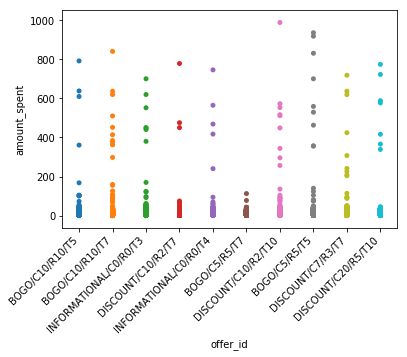

In [110]:
ax = sns.stripplot(x="offer_id", y="amount_spent", data=succ_tried_offers)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0,0,'BOGO/C10/R10/T5'),
 Text(0,0,'BOGO/C10/R10/T7'),
 Text(0,0,'INFORMATIONAL/C0/R0/T3'),
 Text(0,0,'DISCOUNT/C10/R2/T7'),
 Text(0,0,'INFORMATIONAL/C0/R0/T4'),
 Text(0,0,'BOGO/C5/R5/T7'),
 Text(0,0,'DISCOUNT/C10/R2/T10'),
 Text(0,0,'BOGO/C5/R5/T5'),
 Text(0,0,'DISCOUNT/C7/R3/T7'),
 Text(0,0,'DISCOUNT/C20/R5/T10')]

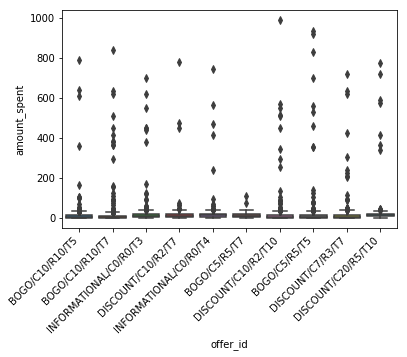

In [111]:
ax = sns.boxplot(x="offer_id", y="amount_spent", data=succ_tried_offers)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

[Text(0,0,'BOGO/C10/R10/T5'),
 Text(0,0,'BOGO/C10/R10/T7'),
 Text(0,0,'INFORMATIONAL/C0/R0/T3'),
 Text(0,0,'DISCOUNT/C10/R2/T7'),
 Text(0,0,'INFORMATIONAL/C0/R0/T4'),
 Text(0,0,'BOGO/C5/R5/T7'),
 Text(0,0,'DISCOUNT/C10/R2/T10'),
 Text(0,0,'BOGO/C5/R5/T5'),
 Text(0,0,'DISCOUNT/C7/R3/T7'),
 Text(0,0,'DISCOUNT/C20/R5/T10')]

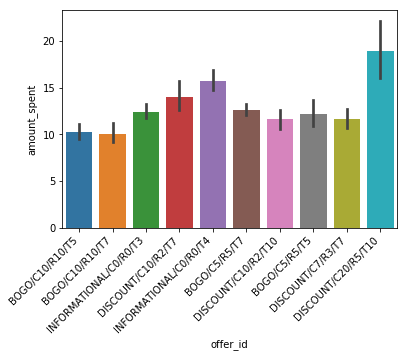

In [112]:
ax = sns.barplot(x="offer_id", y="amount_spent", data=succ_tried_offers)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [113]:
from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import StandardScaler;
from sklearn.svm import SVR;
from sklearn.model_selection import GridSearchCV;
from sklearn.metrics import r2_score;
from sklearn.ensemble import RandomForestRegressor;

In [140]:
succ_tried_offers.columns

Index(['person', 'time_received', 'value', 'type', 'offer_id', 'age',
       'became_member_on', 'income', 'member_year', 'member_month',
       'member_day', 'member_since_days', 'gender_F', 'gender_M', 'gender_O',
       'age_group', 'difficulty', 'duration', 'reward', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_bogo',
       'offer_discount', 'offer_informational', 'time_viewed',
       'time_completed', 'time_of_expiry', 'successful_offer', 'tried_offer',
       'failed_offer', 'time_spent', 'amount_spent', 'spent_during_offer'],
      dtype='object')

In [141]:
X = succ_tried_offers.drop(['amount_spent', 'value', 'type', 'offer_id', 'member_since_days', 'became_member_on', 'person', 'time_viewed', 'time_received', 'time_completed', 'time_of_expiry'], axis=1);
y = succ_tried_offers['amount_spent'];
X.columns

Index(['age', 'income', 'member_year', 'member_month', 'member_day',
       'gender_F', 'gender_M', 'gender_O', 'age_group', 'difficulty',
       'duration', 'reward', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'offer_bogo', 'offer_discount',
       'offer_informational', 'successful_offer', 'tried_offer',
       'failed_offer', 'time_spent', 'spent_during_offer'],
      dtype='object')

In [115]:
scaler = StandardScaler();
X = scaler.fit_transform(X);

In [116]:
X.shape, y.shape

((25254, 24), (25254,))

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2);

In [120]:
X_train.shape, X_test.shape

((20203, 24), (5051, 24))

In [121]:
y_test.isnull().sum()

0

In [122]:
%%time

sv_model = SVR(kernel='poly', degree=7);
sv_model.fit(X_train, y_train);
print('SVR model trained on 7-degree poly kernel')

SVR model trained on 7-degree poly kernel
CPU times: user 35.7 s, sys: 153 ms, total: 35.8 s
Wall time: 36.4 s


In [123]:
%%time

y_preds_svr = sv_model.predict(X_test);
print('SVR Model R2 score: ' , r2_score(y_test, y_preds_svr))

SVR Model R2 score:  0.0398568629587
CPU times: user 2.85 s, sys: 817 µs, total: 2.85 s
Wall time: 2.86 s


In [125]:
%%time

y_preds_svr = sv_model.predict(X_test);
print('SVR Model R2 score: ' , r2_score(y_test, y_preds_svr))

SVR Model R2 score:  0.0398568629587
CPU times: user 2.84 s, sys: 492 µs, total: 2.84 s
Wall time: 2.86 s


In [126]:
%%time

rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=15, min_samples_split=5);
rf_model.fit(X_train, y_train);
print('RF Model trained with 10 estimators')

RF Model trained with 10 estimators
CPU times: user 5.29 s, sys: 20.6 ms, total: 5.31 s
Wall time: 5.32 s


In [127]:
%%time

y_preds_rf = rf_model.predict(X_test);
print('RF Model R2 score: ' , r2_score(y_test, y_preds_rf))

RF Model R2 score:  0.0496444169766
CPU times: user 121 ms, sys: 41 µs, total: 121 ms
Wall time: 122 ms


In [128]:
params = {'n_estimators' : [10, 50, 100], 'max_depth' : [5, 10, 30, 80], \
          'max_features': [1, 3, 8, 15], 'min_samples_split': [3, 5, 10, 30, 50, 100]}

g_rfm = RandomForestRegressor(random_state=1024);
g_src = GridSearchCV(g_rfm, params, verbose=10, cv=5, scoring='r2');

In [129]:
g_src.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=10 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=10, score=0.030921016004542112, total=   0.0s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=10 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=10, score=0.05923634665291744, total=   0.0s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=10 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=10, score=0.04569396587599939, total=   0.0s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=10 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=10, score=0.03811750193124441, total=   0.0s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=10, score=0.041619046917772295, total=   0.0s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=50, score=0.048086282381427314, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=50 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=50, score=0.07544799126777546, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=50 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=50, score=0.06478041824302716, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=50 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=50, score=0.05195772059593673, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=50 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=50, score=0.05291681519463576, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=100, score=0.046564784253514846, total=   0.4s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=100, score=0.07217978341081188, total=   0.4s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=100, score=0.06496420351235555, total=   0.4s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_estimators=100, score=0.05198865177398537, total=   0.4s
[CV] max_depth=5, max_features=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=3, n_es

[CV]  max_depth=5, max_features=1, min_samples_split=30, n_estimators=50, score=0.05273737828380154, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=1, min_samples_split=30, n_estimators=50, score=0.05427569852783454, total=   0.2s
[CV] max_depth=5, max_features=1, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=30, n_estimators=100, score=0.04904789984661695, total=   0.3s
[CV] max_depth=5, max_features=1, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=30, n_estimators=100, score=0.07211595019409445, total=   0.4s
[CV] max_depth=5, max_features=1, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=30, n_estimators=100, score=0.06709204080426867, total=   0.4s
[CV] max_depth=5, max_features=1, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=1, min_samples_split=

[CV]  max_depth=5, max_features=3, min_samples_split=3, n_estimators=50, score=0.08671523092513811, total=   0.3s
[CV] max_depth=5, max_features=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=3, min_samples_split=3, n_estimators=50, score=0.06894796292400329, total=   0.3s
[CV] max_depth=5, max_features=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=3, min_samples_split=3, n_estimators=50, score=0.07124556628976719, total=   0.2s
[CV] max_depth=5, max_features=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=3, min_samples_split=3, n_estimators=100, score=0.06345391745207773, total=   0.5s
[CV] max_depth=5, max_features=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=3, min_samples_split=3, n_estimators=100, score=0.0963793339228336, total=   0.5s
[CV] max_depth=5, max_features=3, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=3, min_samples_split=3, n_estimato

[CV]  max_depth=5, max_features=3, min_samples_split=30, n_estimators=50, score=0.0960152473983572, total=   0.2s
[CV] max_depth=5, max_features=3, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=3, min_samples_split=30, n_estimators=50, score=0.0880827436668089, total=   0.3s
[CV] max_depth=5, max_features=3, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=3, min_samples_split=30, n_estimators=50, score=0.06735045131922046, total=   0.3s
[CV] max_depth=5, max_features=3, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=3, min_samples_split=30, n_estimators=50, score=0.07066332455912805, total=   0.3s
[CV] max_depth=5, max_features=3, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=3, min_samples_split=30, n_estimators=100, score=0.06485581316052003, total=   0.5s
[CV] max_depth=5, max_features=3, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=3, min_samples_split=30, n_

[CV]  max_depth=5, max_features=8, min_samples_split=3, n_estimators=50, score=0.06837095697896478, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=3, n_estimators=50, score=0.1056062634153454, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=3, n_estimators=50, score=0.09598038057958402, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=3, n_estimators=50, score=0.07461938968636572, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=3, n_estimators=50, score=0.08239898836090775, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=8, min_samples_split=3, n_estimators=1

[CV]  max_depth=5, max_features=8, min_samples_split=30, n_estimators=50, score=0.07666334390818963, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=30, n_estimators=50, score=0.10729074361146229, total=   0.4s
[CV] max_depth=5, max_features=8, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=30, n_estimators=50, score=0.10065446713166037, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=30, n_estimators=50, score=0.0816596331312307, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=8, min_samples_split=30, n_estimators=50, score=0.08199006739397974, total=   0.5s
[CV] max_depth=5, max_features=8, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=8, min_samples_split=30, n_e

[CV]  max_depth=5, max_features=15, min_samples_split=3, n_estimators=50, score=0.06088824107241442, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=3, n_estimators=50, score=0.09610980388953883, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=3, n_estimators=50, score=0.10128207681894608, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=3, n_estimators=50, score=0.0720018436044969, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=3, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=3, n_estimators=50, score=0.08036184619836184, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=3, n_estimators=100 
[CV]  max_depth=5, max_features=15, min_samples_split=3, n_e

[CV]  max_depth=5, max_features=15, min_samples_split=30, n_estimators=50, score=0.07516144812691683, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=30, n_estimators=50, score=0.09969287327436072, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=30, n_estimators=50, score=0.09990636700749578, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=30, n_estimators=50, score=0.07735565934892508, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=30, n_estimators=50 
[CV]  max_depth=5, max_features=15, min_samples_split=30, n_estimators=50, score=0.08203538933904753, total=   0.7s
[CV] max_depth=5, max_features=15, min_samples_split=30, n_estimators=100 
[CV]  max_depth=5, max_features=15, min_samples_s

[CV]  max_depth=10, max_features=1, min_samples_split=3, n_estimators=50, score=0.05775691376617842, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=3, n_estimators=50, score=0.09443150403504497, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=3, n_estimators=50, score=0.08406837460704386, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=3, n_estimators=50, score=0.026479952109883298, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=3, n_estimators=50, score=0.0688307517565726, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=3, n_estimators=100 
[CV]  max_depth=10, max_features=1, min_samples_split=3, n_

[CV]  max_depth=10, max_features=1, min_samples_split=30, n_estimators=50, score=0.07014445055309548, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=30, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=30, n_estimators=50, score=0.09707222103663815, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=30, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=30, n_estimators=50, score=0.08631067934588643, total=   0.4s
[CV] max_depth=10, max_features=1, min_samples_split=30, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=30, n_estimators=50, score=0.0653170545078482, total=   0.4s
[CV] max_depth=10, max_features=1, min_samples_split=30, n_estimators=50 
[CV]  max_depth=10, max_features=1, min_samples_split=30, n_estimators=50, score=0.07587571231775148, total=   0.3s
[CV] max_depth=10, max_features=1, min_samples_split=30, n_estimators=100 
[CV]  max_depth=10, max_features=1, min_samples_sp

[CV]  max_depth=10, max_features=3, min_samples_split=3, n_estimators=10, score=-0.011068367740741492, total=   0.1s
[CV] max_depth=10, max_features=3, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=3, min_samples_split=3, n_estimators=10, score=0.01083173920414171, total=   0.1s
[CV] max_depth=10, max_features=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=3, min_samples_split=3, n_estimators=50, score=0.061817371595863424, total=   0.4s
[CV] max_depth=10, max_features=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=3, min_samples_split=3, n_estimators=50, score=0.08602450802335981, total=   0.4s
[CV] max_depth=10, max_features=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=3, min_samples_split=3, n_estimators=50, score=0.081905217263742, total=   0.4s
[CV] max_depth=10, max_features=3, min_samples_split=3, n_estimators=50 
[CV]  max_depth=10, max_features=3, min_samples_split=3, n_

[CV]  max_depth=10, max_features=3, min_samples_split=100, n_estimators=100, score=0.08333606500511437, total=   0.7s
[CV] max_depth=10, max_features=8, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=3, n_estimators=10, score=0.02404177013025144, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=3, n_estimators=10, score=-0.07704629412563202, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=3, n_estimators=10, score=-0.01997182056521485, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=3, n_estimators=10, score=-0.11417800957690627, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=

[CV]  max_depth=10, max_features=8, min_samples_split=10, n_estimators=100, score=0.06337173049853384, total=   1.5s
[CV] max_depth=10, max_features=8, min_samples_split=10, n_estimators=100 
[CV]  max_depth=10, max_features=8, min_samples_split=10, n_estimators=100, score=0.07994093716945916, total=   1.5s
[CV] max_depth=10, max_features=8, min_samples_split=30, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=30, n_estimators=10, score=0.062093192859795865, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=30, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=30, n_estimators=10, score=0.0679145733094888, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=30, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples_split=30, n_estimators=10, score=0.06991657164424958, total=   0.2s
[CV] max_depth=10, max_features=8, min_samples_split=30, n_estimators=10 
[CV]  max_depth=10, max_features=8, min_samples

[CV]  max_depth=10, max_features=8, min_samples_split=100, n_estimators=100, score=0.11108933437956103, total=   1.4s
[CV] max_depth=10, max_features=8, min_samples_split=100, n_estimators=100 
[CV]  max_depth=10, max_features=8, min_samples_split=100, n_estimators=100, score=0.10498686047698103, total=   1.4s
[CV] max_depth=10, max_features=8, min_samples_split=100, n_estimators=100 
[CV]  max_depth=10, max_features=8, min_samples_split=100, n_estimators=100, score=0.08086590403164695, total=   1.4s
[CV] max_depth=10, max_features=8, min_samples_split=100, n_estimators=100 
[CV]  max_depth=10, max_features=8, min_samples_split=100, n_estimators=100, score=0.08884418814975548, total=   1.4s
[CV] max_depth=10, max_features=15, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=15, min_samples_split=3, n_estimators=10, score=-0.12204643372929436, total=   0.3s
[CV] max_depth=10, max_features=15, min_samples_split=3, n_estimators=10 
[CV]  max_depth=10, max_features=15

[CV]  max_depth=10, max_features=15, min_samples_split=10, n_estimators=50, score=0.0690625061281841, total=   1.3s
[CV] max_depth=10, max_features=15, min_samples_split=10, n_estimators=100 
[CV]  max_depth=10, max_features=15, min_samples_split=10, n_estimators=100, score=0.02566532293128887, total=   2.5s
[CV] max_depth=10, max_features=15, min_samples_split=10, n_estimators=100 
[CV]  max_depth=10, max_features=15, min_samples_split=10, n_estimators=100, score=0.07019933629823949, total=   2.6s
[CV] max_depth=10, max_features=15, min_samples_split=10, n_estimators=100 
[CV]  max_depth=10, max_features=15, min_samples_split=10, n_estimators=100, score=0.0670323340755018, total=   2.6s
[CV] max_depth=10, max_features=15, min_samples_split=10, n_estimators=100 
[CV]  max_depth=10, max_features=15, min_samples_split=10, n_estimators=100, score=0.044018932496002305, total=   2.6s
[CV] max_depth=10, max_features=15, min_samples_split=10, n_estimators=100 
[CV]  max_depth=10, max_features

[CV]  max_depth=10, max_features=15, min_samples_split=100, n_estimators=50, score=0.10350626131687157, total=   1.2s
[CV] max_depth=10, max_features=15, min_samples_split=100, n_estimators=50 
[CV]  max_depth=10, max_features=15, min_samples_split=100, n_estimators=50, score=0.0762903587376833, total=   1.2s
[CV] max_depth=10, max_features=15, min_samples_split=100, n_estimators=50 
[CV]  max_depth=10, max_features=15, min_samples_split=100, n_estimators=50, score=0.08444225627571411, total=   1.2s
[CV] max_depth=10, max_features=15, min_samples_split=100, n_estimators=100 
[CV]  max_depth=10, max_features=15, min_samples_split=100, n_estimators=100, score=0.07801817595122196, total=   2.4s
[CV] max_depth=10, max_features=15, min_samples_split=100, n_estimators=100 
[CV]  max_depth=10, max_features=15, min_samples_split=100, n_estimators=100, score=0.10386021929136147, total=   2.4s
[CV] max_depth=10, max_features=15, min_samples_split=100, n_estimators=100 
[CV]  max_depth=10, max_fe

[CV]  max_depth=30, max_features=1, min_samples_split=10, n_estimators=50, score=0.10080033481100459, total=   0.5s
[CV] max_depth=30, max_features=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=10, n_estimators=50, score=0.08961001899169085, total=   0.8s
[CV] max_depth=30, max_features=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=10, n_estimators=50, score=0.06119812118904555, total=   0.5s
[CV] max_depth=30, max_features=1, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=10, n_estimators=50, score=0.08266197862683389, total=   0.5s
[CV] max_depth=30, max_features=1, min_samples_split=10, n_estimators=100 
[CV]  max_depth=30, max_features=1, min_samples_split=10, n_estimators=100, score=0.07058414884678443, total=   0.9s
[CV] max_depth=30, max_features=1, min_samples_split=10, n_estimators=100 
[CV]  max_depth=30, max_features=1, min_samples

[CV]  max_depth=30, max_features=1, min_samples_split=100, n_estimators=50, score=0.06835516327549895, total=   0.3s
[CV] max_depth=30, max_features=1, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=100, n_estimators=50, score=0.10091937254711436, total=   0.3s
[CV] max_depth=30, max_features=1, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=100, n_estimators=50, score=0.09461340284785646, total=   0.3s
[CV] max_depth=30, max_features=1, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=100, n_estimators=50, score=0.07150403306490283, total=   0.3s
[CV] max_depth=30, max_features=1, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=1, min_samples_split=100, n_estimators=50, score=0.07587199177669324, total=   0.3s
[CV] max_depth=30, max_features=1, min_samples_split=100, n_estimators=100 
[CV]  max_depth=30, max_features=1, min

[CV]  max_depth=30, max_features=3, min_samples_split=10, n_estimators=50, score=0.07816090489621508, total=   0.6s
[CV] max_depth=30, max_features=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=10, n_estimators=50, score=0.11219887783690108, total=   0.6s
[CV] max_depth=30, max_features=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=10, n_estimators=50, score=0.09454947039973605, total=   0.6s
[CV] max_depth=30, max_features=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=10, n_estimators=50, score=0.052151459782660226, total=   0.6s
[CV] max_depth=30, max_features=3, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=10, n_estimators=50, score=0.08540198248587738, total=   0.6s
[CV] max_depth=30, max_features=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=30, max_features=3, min_samples_

[CV]  max_depth=30, max_features=3, min_samples_split=100, n_estimators=10, score=0.07903690001689534, total=   0.1s
[CV] max_depth=30, max_features=3, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=100, n_estimators=50, score=0.07519702175919563, total=   0.4s
[CV] max_depth=30, max_features=3, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=100, n_estimators=50, score=0.11153656777867227, total=   0.7s
[CV] max_depth=30, max_features=3, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=100, n_estimators=50, score=0.10604733727621585, total=   0.4s
[CV] max_depth=30, max_features=3, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_samples_split=100, n_estimators=50, score=0.08288130763360124, total=   0.4s
[CV] max_depth=30, max_features=3, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=3, min_

[CV]  max_depth=30, max_features=8, min_samples_split=10, n_estimators=10, score=-0.017274179671450174, total=   0.2s
[CV] max_depth=30, max_features=8, min_samples_split=10, n_estimators=10 
[CV]  max_depth=30, max_features=8, min_samples_split=10, n_estimators=10, score=0.05389079697325905, total=   0.2s
[CV] max_depth=30, max_features=8, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=8, min_samples_split=10, n_estimators=50, score=0.06505819451577932, total=   1.1s
[CV] max_depth=30, max_features=8, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=8, min_samples_split=10, n_estimators=50, score=0.10063418085664144, total=   1.4s
[CV] max_depth=30, max_features=8, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=8, min_samples_split=10, n_estimators=50, score=0.07184396829019724, total=   1.1s
[CV] max_depth=30, max_features=8, min_samples_split=10, n_estimators=50 
[CV]  max_depth=30, max_features=8, min_samples_

[CV]  max_depth=30, max_features=8, min_samples_split=100, n_estimators=10, score=0.10059740617418655, total=   0.2s
[CV] max_depth=30, max_features=8, min_samples_split=100, n_estimators=10 
[CV]  max_depth=30, max_features=8, min_samples_split=100, n_estimators=10, score=0.0950153513730595, total=   0.2s
[CV] max_depth=30, max_features=8, min_samples_split=100, n_estimators=10 
[CV]  max_depth=30, max_features=8, min_samples_split=100, n_estimators=10, score=0.08303639732482981, total=   0.2s
[CV] max_depth=30, max_features=8, min_samples_split=100, n_estimators=10 
[CV]  max_depth=30, max_features=8, min_samples_split=100, n_estimators=10, score=0.08385804799514784, total=   0.2s
[CV] max_depth=30, max_features=8, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=8, min_samples_split=100, n_estimators=50, score=0.08165029562534487, total=   0.7s
[CV] max_depth=30, max_features=8, min_samples_split=100, n_estimators=50 
[CV]  max_depth=30, max_features=8, min_s

[CV]  max_depth=30, max_features=15, min_samples_split=5, n_estimators=100, score=0.04690977019192755, total=   4.4s
[CV] max_depth=30, max_features=15, min_samples_split=10, n_estimators=10 
[CV]  max_depth=30, max_features=15, min_samples_split=10, n_estimators=10, score=-0.05531650956180978, total=   0.4s
[CV] max_depth=30, max_features=15, min_samples_split=10, n_estimators=10 
[CV]  max_depth=30, max_features=15, min_samples_split=10, n_estimators=10, score=-0.027166946869529696, total=   0.4s
[CV] max_depth=30, max_features=15, min_samples_split=10, n_estimators=10 
[CV]  max_depth=30, max_features=15, min_samples_split=10, n_estimators=10, score=-0.0115254417328301, total=   0.4s
[CV] max_depth=30, max_features=15, min_samples_split=10, n_estimators=10 
[CV]  max_depth=30, max_features=15, min_samples_split=10, n_estimators=10, score=0.012039161927009268, total=   0.4s
[CV] max_depth=30, max_features=15, min_samples_split=10, n_estimators=10 
[CV]  max_depth=30, max_features=15,

[CV]  max_depth=30, max_features=15, min_samples_split=50, n_estimators=100, score=0.10137369037546407, total=   3.0s
[CV] max_depth=30, max_features=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=30, max_features=15, min_samples_split=50, n_estimators=100, score=0.07504717806677252, total=   2.9s
[CV] max_depth=30, max_features=15, min_samples_split=50, n_estimators=100 
[CV]  max_depth=30, max_features=15, min_samples_split=50, n_estimators=100, score=0.08783111078780448, total=   2.9s
[CV] max_depth=30, max_features=15, min_samples_split=100, n_estimators=10 
[CV]  max_depth=30, max_features=15, min_samples_split=100, n_estimators=10, score=0.06895449967178191, total=   0.3s
[CV] max_depth=30, max_features=15, min_samples_split=100, n_estimators=10 
[CV]  max_depth=30, max_features=15, min_samples_split=100, n_estimators=10, score=0.09540395801837176, total=   0.3s
[CV] max_depth=30, max_features=15, min_samples_split=100, n_estimators=10 
[CV]  max_depth=30, max_featur

[CV]  max_depth=80, max_features=1, min_samples_split=5, n_estimators=100, score=0.05213763903250179, total=   1.1s
[CV] max_depth=80, max_features=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=5, n_estimators=100, score=0.11882559780276503, total=   1.1s
[CV] max_depth=80, max_features=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=5, n_estimators=100, score=0.07704264087973212, total=   1.1s
[CV] max_depth=80, max_features=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=5, n_estimators=100, score=0.045909745230971466, total=   1.1s
[CV] max_depth=80, max_features=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=5, n_estimators=100, score=0.08385673051634246, total=   1.1s
[CV] max_depth=80, max_features=1, min_samples_split=10, n_estimators=10 
[CV]  max_depth=80, max_features=1, min_samples_s

[CV]  max_depth=80, max_features=1, min_samples_split=50, n_estimators=50, score=0.08173482973344448, total=   0.3s
[CV] max_depth=80, max_features=1, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=50, n_estimators=100, score=0.06875676436275457, total=   0.6s
[CV] max_depth=80, max_features=1, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=50, n_estimators=100, score=0.1105345664289249, total=   0.7s
[CV] max_depth=80, max_features=1, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=50, n_estimators=100, score=0.09596786914031019, total=   1.0s
[CV] max_depth=80, max_features=1, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_samples_split=50, n_estimators=100, score=0.07156135981597667, total=   0.7s
[CV] max_depth=80, max_features=1, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=1, min_sa

[CV]  max_depth=80, max_features=3, min_samples_split=5, n_estimators=50, score=0.07682985506448303, total=   0.7s
[CV] max_depth=80, max_features=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=3, min_samples_split=5, n_estimators=50, score=0.029759750131962637, total=   0.7s
[CV] max_depth=80, max_features=3, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=3, min_samples_split=5, n_estimators=50, score=0.06598513230373071, total=   1.0s
[CV] max_depth=80, max_features=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=3, min_samples_split=5, n_estimators=100, score=0.06040125259158058, total=   1.4s
[CV] max_depth=80, max_features=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=3, min_samples_split=5, n_estimators=100, score=0.11609719665461671, total=   1.4s
[CV] max_depth=80, max_features=3, min_samples_split=5, n_estimators=100 
[CV]  max_depth=80, max_features=3, min_samples_split=

[CV]  max_depth=80, max_features=3, min_samples_split=50, n_estimators=50, score=0.11299471557718987, total=   0.5s
[CV] max_depth=80, max_features=3, min_samples_split=50, n_estimators=50 
[CV]  max_depth=80, max_features=3, min_samples_split=50, n_estimators=50, score=0.1005670219015643, total=   0.4s
[CV] max_depth=80, max_features=3, min_samples_split=50, n_estimators=50 
[CV]  max_depth=80, max_features=3, min_samples_split=50, n_estimators=50, score=0.07974778482757594, total=   0.4s
[CV] max_depth=80, max_features=3, min_samples_split=50, n_estimators=50 
[CV]  max_depth=80, max_features=3, min_samples_split=50, n_estimators=50, score=0.08620707083225532, total=   0.4s
[CV] max_depth=80, max_features=3, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=3, min_samples_split=50, n_estimators=100, score=0.07779296379936962, total=   0.9s
[CV] max_depth=80, max_features=3, min_samples_split=50, n_estimators=100 
[CV]  max_depth=80, max_features=3, min_samples_

[CV]  max_depth=80, max_features=8, min_samples_split=5, n_estimators=10, score=0.007260009007673096, total=   0.3s
[CV] max_depth=80, max_features=8, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=5, n_estimators=50, score=0.02186613514495961, total=   1.3s
[CV] max_depth=80, max_features=8, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=5, n_estimators=50, score=0.0780482202656011, total=   1.3s
[CV] max_depth=80, max_features=8, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=5, n_estimators=50, score=0.062178144780246636, total=   1.3s
[CV] max_depth=80, max_features=8, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=5, n_estimators=50, score=0.002856970173327311, total=   1.3s
[CV] max_depth=80, max_features=8, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=5, n

[CV] max_depth=80, max_features=8, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=8, min_samples_split=50, n_estimators=10, score=0.06023504907383925, total=   0.2s
[CV] max_depth=80, max_features=8, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=8, min_samples_split=50, n_estimators=10, score=0.07898463979974835, total=   0.2s
[CV] max_depth=80, max_features=8, min_samples_split=50, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=50, n_estimators=50, score=0.08269988394058303, total=   0.8s
[CV] max_depth=80, max_features=8, min_samples_split=50, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=50, n_estimators=50, score=0.10797357200714464, total=   0.9s
[CV] max_depth=80, max_features=8, min_samples_split=50, n_estimators=50 
[CV]  max_depth=80, max_features=8, min_samples_split=50, n_estimators=50, score=0.10541847499977408, total=   0.9s
[CV] max_depth=80, max_features=8, min_samples_spl

[CV]  max_depth=80, max_features=15, min_samples_split=5, n_estimators=10, score=-0.09982746155803435, total=   0.4s
[CV] max_depth=80, max_features=15, min_samples_split=5, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=5, n_estimators=10, score=-0.15415637420226247, total=   0.4s
[CV] max_depth=80, max_features=15, min_samples_split=5, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=5, n_estimators=10, score=-0.037489749746618006, total=   0.4s
[CV] max_depth=80, max_features=15, min_samples_split=5, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=5, n_estimators=10, score=0.0005296342026763767, total=   0.4s
[CV] max_depth=80, max_features=15, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=15, min_samples_split=5, n_estimators=50, score=-0.0016243200551009362, total=   2.3s
[CV] max_depth=80, max_features=15, min_samples_split=5, n_estimators=50 
[CV]  max_depth=80, max_features=15, min_

[CV]  max_depth=80, max_features=15, min_samples_split=30, n_estimators=100, score=0.08331148146371548, total=   3.2s
[CV] max_depth=80, max_features=15, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=50, n_estimators=10, score=0.06138474425917795, total=   0.3s
[CV] max_depth=80, max_features=15, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=50, n_estimators=10, score=0.08152755176908821, total=   0.3s
[CV] max_depth=80, max_features=15, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=50, n_estimators=10, score=0.08577377016850607, total=   0.3s
[CV] max_depth=80, max_features=15, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=15, min_samples_split=50, n_estimators=10, score=0.07365253682367157, total=   0.3s
[CV] max_depth=80, max_features=15, min_samples_split=50, n_estimators=10 
[CV]  max_depth=80, max_features=15, mi

[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 22.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1024, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 30, 80], 'max_features': [1, 3, 8, 15], 'min_samples_split': [3, 5, 10, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=10)

In [130]:
g_src.best_params_

{'max_depth': 30,
 'max_features': 8,
 'min_samples_split': 50,
 'n_estimators': 100}

In [131]:
tuned_rf_model = RandomForestRegressor(max_depth=30, max_features=3, min_samples_split=100, n_estimators=100);

In [132]:
tuned_rf_model.fit(X_train, y_train);

In [133]:
y_preds_tuned = tuned_rf_model.predict(X_test);

In [134]:
r2_score(y_test, y_preds_tuned)

0.069353469323635397

In [357]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(tuned_rf_model, open(filename, 'wb'))

In [139]:
test_1 = succ_tried_offers.drop(['amount_spent', 'value', 'type', 'offer_id', 'member_since_days', 'became_member_on', 'person', 'time_viewed', 'time_received', 'time_completed', 'time_of_expiry'], axis=1)
pd.DataFrame(list(zip(test_1.columns[2:], tuned_rf_model.feature_importances_)), columns=['Attribute', 'Feature Importance']).sort_values(by='Feature Importance', ascending=False)

,Attribute,Feature Importance
1,member_month,0.337300
0,member_year,0.104086
20,time_spent,0.075126
19,failed_offer,0.066673
2,member_day,0.054806
4,gender_M,0.050845
3,gender_F,0.035048
8,duration,0.032955
9,reward,0.028852
6,age_group,0.021795


In [273]:
persons_per_offer = succ_tried_offers.groupby('offer_id').count()['spent_during_offer']
persons_per_offer

offer_id
BOGO/C10/R10/T5           3397
BOGO/C10/R10/T7           3396
BOGO/C5/R5/T5             2744
BOGO/C5/R5/T7             1244
DISCOUNT/C10/R2/T10       3219
DISCOUNT/C10/R2/T7        1333
DISCOUNT/C20/R5/T10        941
DISCOUNT/C7/R3/T7         2802
INFORMATIONAL/C0/R0/T3    4058
INFORMATIONAL/C0/R0/T4    2120
Name: spent_during_offer, dtype: int64

In [151]:
amount_spent_per_offer = succ_tried_offers.groupby('offer_id').sum()['amount_spent']
amount_spent_per_offer

offer_id
BOGO/C10/R10/T5           34683.95
BOGO/C10/R10/T7           34212.81
BOGO/C5/R5/T5             33414.67
BOGO/C5/R5/T7             15701.44
DISCOUNT/C10/R2/T10       37369.84
DISCOUNT/C10/R2/T7        18626.06
DISCOUNT/C20/R5/T10       17789.39
DISCOUNT/C7/R3/T7         32557.62
INFORMATIONAL/C0/R0/T3    50485.06
INFORMATIONAL/C0/R0/T4    33389.93
Name: amount_spent, dtype: float64

In [298]:
succ_tried_offers['member_year'].value_counts()

2017.0    8726
2016.0    5660
2018.0    4380
2015.0    3513
2014.0    2109
2013.0     866
Name: member_year, dtype: int64